In [1]:
import matplotlib.pyplot as plt
import numpy as np
from alternative_ford import bellman_ford, greedy_ford, decay_ford, noisy_ford
import seaborn as sns

Notebook to generate Figure 4 from the paper.

In [2]:
data = np.load('../trajs.npz', allow_pickle=True)
inputs = data['inputs']
score = data['score']
lengths = data['lengths']
trajs = data['trajs']
outputs = data['outputs']
hints = data['hints']

In [3]:
n = inputs[0].data.shape[0]
n

16384

In [4]:
lengths

array([ 7,  9,  8, ..., 11,  8,  7])

In [5]:
all_hints = np.array([x['pi_h'] for x in hints[:9]])[:,lengths==9,...]

In [6]:
allpreds = np.argmax(all_hints, axis=-1)
allpreds.shape

(9, 4047, 64)

In [7]:
narpreds = allpreds[-1]
narpreds.shape

(4047, 64)

In [8]:
allAs = np.array([inputs[2].data[i, ...] for i in range(n)])[lengths==9]
allss = np.array([np.argmax(inputs[1].data[i, ...]) for i in range(n)])[lengths==9]

In [9]:
bf_out = [bellman_ford(allAs[i], allss[i], 9) for i in range(allss.shape[0])]

In [10]:
all_preds = np.array([x[0] for x in bf_out])
all_preds.shape

(4047, 9, 64)

In [11]:
true_preds = all_preds[:,-1,:]
true_preds.shape

(4047, 64)

In [12]:
decay_out = np.array([decay_ford(allAs[i], allss[i], 9) for i in range(allss.shape[0])])

In [13]:
decay_preds = decay_out[:,-1,:]
decay_preds.shape

(4047, 64)

In [14]:
greedy_out =  np.array([greedy_ford(allAs[i], allss[i], 9) for i in range(allss.shape[0])])

In [15]:
greedy_preds = greedy_out[:,-1,:]
greedy_preds.shape

(4047, 64)

In [16]:
noisy_out =  np.array([noisy_ford(allAs[i], allss[i], 9) for i in range(allss.shape[0])])

In [17]:
noisy_preds = noisy_out[:,-1,:]
noisy_preds.shape

(4047, 64)

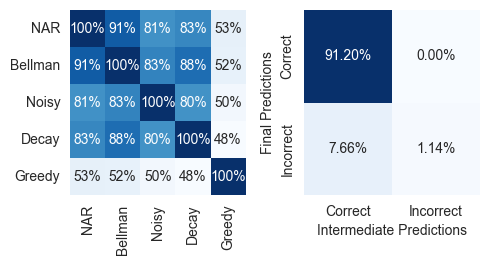

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5,2.75))

#ax1

x = [narpreds, true_preds, noisy_preds, decay_preds, greedy_preds]
total = narpreds.reshape(-1, 1).shape[0]
conf = np.array([[np.count_nonzero(x[i]==x[j]) / total for i in range(5)] for j in range(5)])
labels = ['NAR', 'Bellman', 'Noisy', 'Decay', 'Greedy']

sns.heatmap(conf, annot=True, fmt='.0%', cbar=False, cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax1)

#ax2

was_true = np.any(allpreds == true_preds, axis=0)
is_true = narpreds == true_preds
change = np.array([[np.count_nonzero(was_true & is_true), np.count_nonzero((~was_true) & is_true)],
          [np.count_nonzero(was_true & (~is_true)), np.count_nonzero((~was_true) & (~is_true))]]) / total
labels = ['Correct', 'Incorrect']

sns.heatmap(change, annot=True, fmt='.2%', cbar=False, cmap='Blues',xticklabels=labels, yticklabels=labels, ax=ax2)

ax2.set_xlabel('Intermediate Predictions')
ax2.set_ylabel('Final Predictions')

#

fig.tight_layout()
fig.savefig('plots_new/4.png', dpi=400)
